<a href="https://colab.research.google.com/github/yuanjinren/DS-Unit-2-Kaggle-Challenge/blob/master/YuanjinRen_DS_Sprint_Challenge_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll predict whether each shot was made, using information about the shot and the game. This is hard to predict! Try to get above 60% accuracy. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

In [0]:
# Read data
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)

# Check data shape
assert df.shape == (13958, 20)

To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

You are permitted and encouraged to do as much data exploration as you want.

**1. Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is your baseline accuracy, if you guessed the majority class for every prediction?

**2. Hold out your test set.** Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

**3. Engineer new feature.** Engineer at least **1** new feature, from this list, or your own idea.
- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**4. Decide how to validate** your model. Choose one of the following options. Any of these options are good. You are not graded on which you choose.
- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
- **Train/validate/test split: random 80/20%** train/validate split.
- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

**5.** Use a scikit-learn **pipeline** to **encode categoricals** and fit a **Decision Tree** or **Random Forest** model.

**6.** Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.) 

**7.** Get your model's **test accuracy.** (One time, at the end.)


**8.** Given a **confusion matrix** for a hypothetical binary classification model, **calculate accuracy, precision, and recall.**

### Stretch Goals
- Engineer 4+ new features total, either from the list above, or your own ideas.
- Make 2+ visualizations to explore relationships between features and target.
- Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters). You can use `RandomizedSearchCV` or do it manually.
- Get and plot your model's feature importances.



## 1. Begin with baselines for classification. 

>Your target to predict is `shot_made_flag`. What would your baseline accuracy be, if you guessed the majority class for every prediction?

In [0]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0


Baseline accuracy, if just guess the majority class for every prediction

In [0]:
target = 'shot_made_flag'

In [0]:
df[target].value_counts(normalize=True)

0    0.527081
1    0.472919
Name: shot_made_flag, dtype: float64

In [0]:
majority_class = df[target].mode()
majority_class

0    0
dtype: int64

In [0]:
df_pred = [majority_class] * len(df[target])

In [0]:
from sklearn.metrics import accuracy_score
accuracy_score(df[target], df_pred)

0.5270812437311936

## 2. Hold out your test set.

>Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

In [0]:
df['game_date'] = pd.to_datetime(df['game_date'],infer_datetime_format=True)
condition = (df['game_date']<'2019-06-30') & (df['game_date'] >'2018-10-01')
test = df[condition]
test.shape

(1709, 20)

## 3. Engineer new feature.

>Engineer at least **1** new feature, from this list, or your own idea.
>
>- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
>- **Opponent**: Who is the other team playing the Golden State Warriors?
>- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
>- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
>- **Made previous shot**: Was Steph Curry's previous shot successful?

    

In [0]:
def wrangle(X):
  X=X.copy()
  X['seconds_remaining_period'] = X ['minutes_remaining'] * 60 + X['seconds_remaining']
  X['seconds_remaining_game'] = ((4-X['period'])*12*60) + X['minutes_remaining'] * 60 + X['seconds_remaining']
  X = X.drop(columns=['game_id','game_event_id','player_name'])

  return X

In [0]:
df = wrangle(df)
test = wrangle(test)

In [0]:
df.head()

,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,seconds_remaining_period,seconds_remaining_game
0,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0,685,2845
1,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0,571,2731
2,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0,362,2522
3,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0,589,2029
4,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0,139,1579


## **4. Decide how to validate** your model. 

>Choose one of the following options. Any of these options are good. You are not graded on which you choose.
>
>- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
>- **Train/validate/test split: random 80/20%** train/validate split.
>- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

In [0]:
condition_train = (df['game_date'] >'2009-10-01') & (df['game_date'] <'2017-06-30')
condition_val =  (df['game_date'] >'2017-10-01') & (df['game_date'] <'2018-06-30')
train = df[condition_train]
val = df[condition_val]
train.shape, val.shape

((11081, 19), (1168, 19))

In [0]:
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns=target)
y_test = test[target]

In [0]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((11081, 18), (11081,), (1168, 18), (1168,), (1709, 18), (1709,))

## 5. Use a scikit-learn pipeline to encode categoricals and fit a Decision Tree or Random Forest model.

In [0]:
# get rid of the 'game_date' column, since it has date format data, it will not fit in the decision tree model later
def datewrangle(Y):
  Y['game_year'] = Y['game_date'].dt.year
  Y['game_month'] = Y['game_date'].dt.month
  Y['game_day'] = Y['game_date'].dt.day
  Y=Y.drop(columns='game_date')
  return Y

In [0]:
X_train = datewrangle(X_train)
X_val = datewrangle(X_val)
X_test = datewrangle(X_test)

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

In [0]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['action_type', 'shot_type',
                                      'shot_zone_basic', 'shot_zone_area',
                                      'shot_zone_range', 'htm', 'vtm',
                                      'season_type'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'action_type',
                                          'data_type': dtype('O'),
                                          'mapping': Jump Shot                              1
Step Back Jump shot                    2
Pullup Jump shot                       3
Layup S...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',


In [0]:
print(f'Train accuracy: {pipeline.score(X_train, y_train)}')

Train accuracy: 1.0


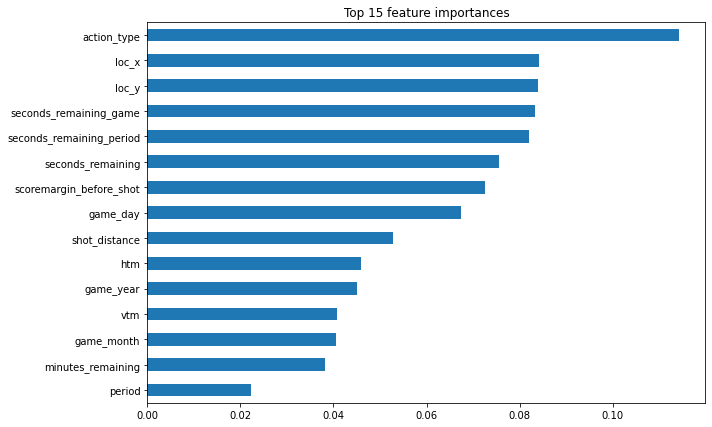

In [0]:
import matplotlib.pyplot as plt
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)
n = 15
plt.figure(figsize=(10,7))
plt.title(f'Top {n} feature importances')
importances.sort_values()[-n:].plot.barh();

## 6.Get your model's validation accuracy

> (Multiple times if you try multiple iterations.)

In [0]:
print(f'Validation accuracy: {pipeline.score(X_val, y_val)}')

Validation accuracy: 0.583904109589041


Hyperparameter optimization

In [0]:
print('Model Hyperparameters:')
print(pipeline.named_steps['randomforestclassifier'])

Model Hyperparameters:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [0]:
from scipy.stats import randint, uniform
param_distributions = {
    'randomforestclassifier__bootstrap' :['True', 'False'],
    'randomforestclassifier__n_estimators':[50,80,100,150,200],
    'randomforestclassifier__min_samples_leaf':[1,2,4],
    'randomforestclassifier__max_features':['auto','sqrt'],
    'randomforestclassifier__min_samples_split':[2,5,10]
}

In [0]:
from sklearn.model_selection import RandomizedSearchCV
search = RandomizedSearchCV(
    pipeline,
    param_distributions,
    n_iter=10,
    scoring='accuracy',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.7min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['action_type',
                                                                   'shot_type',
                                                                   'shot_zone_basic',
                                                                   'shot_zone_area',
                                                                   'shot_zone_range',
                                                                   'htm', 'vtm',
                                                                   'season_type'],
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
    

In [0]:
print('Best Hyperparameters', search.best_params_)

Best Hyperparameters {'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__bootstrap': 'False'}


In [0]:
pipeline = search.best_estimator_

In [0]:
print(f'Validation accuracy after parameters tuning: {pipeline.score(X_val, y_val)}')

Validation accuracy after parameters tuning: 0.6027397260273972


## 7. Get your model's test accuracy

> (One time, at the end.)

In [0]:
y_test_pred = pipeline.predict(X_test)

In [0]:
from sklearn.metrics import accuracy_score
print(f'test accuracy is: {accuracy_score(y_test, y_test_pred)}')

test accuracy is: 0.6325336454066706


## 8. Given a confusion matrix, calculate accuracy, precision, and recall.

Imagine this is the confusion matrix for a binary classification model. Use the confusion matrix to calculate the model's accuracy, precision, and recall.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

### Calculate accuracy 

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred)
cm

array([[557, 355],
       [273, 524]])

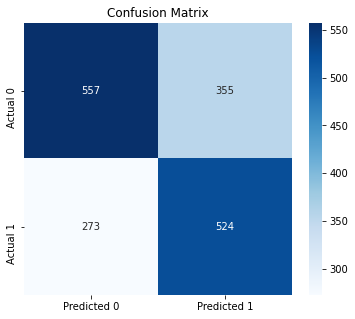

In [0]:
import seaborn as sns
from sklearn.utils.multiclass import unique_labels

def plot_cm(y_test, y_pred, normalize=False):
  cols = unique_labels(y_test)
  cm = confusion_matrix(y_test, y_pred)
  if normalize:
    cm = cm/cm.sum(axis=1)[:, np.newaxis]
    fmt = '.2f'
  else:
    fmt = '.0f'
  df_cm = pd.DataFrame(cm, columns = ['Predicted ' + str(col) for col in cols], 
                       index = ['Actual ' + str(col) for col in cols])
  plt.figure(figsize=(6,5))
  sns.heatmap(df_cm, annot=True, cmap='Blues', fmt=fmt)
  plt.title('Confusion Matrix')

plot_cm(y_test, y_test_pred)

In [0]:
accuracy = np.diag(cm).sum()/cm.sum()
print(f'Accuracy is: {accuracy}')

Accuracy is: 0.6325336454066706


### Calculate precision

In [0]:
# total prediction of 'shot_made_flag is 1'
total_pred_shot_made = 355 + 524
correct_pred_shot_made = 524
precision_shot_made = correct_pred_shot_made/total_pred_shot_made
print(precision_shot_made)

0.59613196814562


### Calculate recall

In [0]:
actual_shot_made = 273 + 524
actual_shot_made

797

In [0]:
recall_shot_made = correct_pred_shot_made/actual_shot_made
recall_shot_made

0.657465495608532

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.67      0.61      0.64       912
           1       0.60      0.66      0.63       797

    accuracy                           0.63      1709
   macro avg       0.63      0.63      0.63      1709
weighted avg       0.64      0.63      0.63      1709

